In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import scipy
import scipy.spatial
import progressbar

# Overview

In this notebook I will be attempting to compare depth (distance based) to a guassian kde - to emphasis that depth (local or otherwise) focus more on geometric features than kernel density destimates. It would probably be best to do a local malahnobis depth vs a kde (since they are even closer - but I think this is good as distance depth also coded and has similarities to other depths.

In [2]:
np.random.seed(1)
data = np.random.uniform(size = (1000,2))

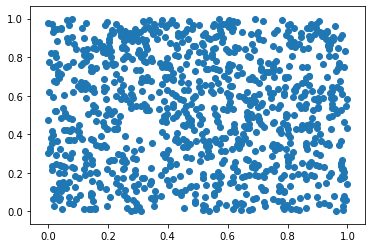

In [3]:
plt.scatter(data[:,0], data[:,1])

In [4]:
def remove_idx(i,n):
    return np.concatenate([np.arange(i),np.arange(i+1,n)])

def local_distance_depth_function(dist_matrix, tau = np.inf):
    """
    calculates a depth vector using a distance matrix

    Arguments:
    ----------
    dist_matrix: np.array (n,n)
        square positive symmetric matrix
    tau : non-negative scalar constains which 

    Returns:
    --------
    depth: np.array (n,) 
        vector with depth values associated with indices in dist_matrix
    """
    N = dist_matrix.shape[0]
    
    if (N != dist_matrix.shape[1]) or \
        (np.any(dist_matrix.T != dist_matrix)) or \
        (np.any(dist_matrix < 0)):
        stop("this is not a positive symmetric square matrix")

    depth = np.zeros(N)
  

    for obs_index in np.arange(N):
        # vector of idx to keep (not associated with idx examining) 
        rm_idx = remove_idx(obs_index, N)
        # from symmetry:
        dist_to_obs = dist_matrix[obs_index, rm_idx]
        keep_idx = rm_idx[dist_to_obs <= tau]
        
        sub_matrix = dist_matrix[keep_idx,][:,keep_idx]
        N_inner = sub_matrix.shape[0]
        
        obs_column = dist_matrix[keep_idx,obs_index]
        obs_row    = dist_matrix[obs_index,keep_idx]
        
        obs_column_matrix = np.tile(obs_column, (N_inner,1))
        obs_row_matrix    = np.tile(obs_column, (N_inner,1)).T 
        
        obs_combo_array = np.zeros((N_inner, N_inner, 2))
        obs_combo_array[:,:,0] = obs_column_matrix
        obs_combo_array[:,:,1] = obs_row_matrix

        max_matrix = obs_combo_array.max(axis = 2)

        min_matrix = obs_combo_array.min(axis = 2)

        max_part = np.mean((sub_matrix > max_matrix)[
            ~np.eye(min_matrix.shape[0],dtype=bool) #ignore diagonal
        ])

        
        depth[obs_index] = max_part
    return(depth)

In [5]:
dist_mat = scipy.spatial.distance_matrix(x = data, y = data)
gdepth = local_distance_depth_function(dist_mat)

## global depth

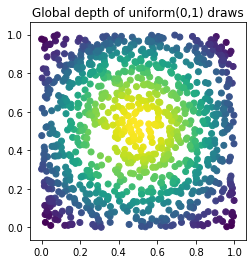

In [23]:
fig, ax = plt.subplots(nrows = 1)
ax.scatter(data[:,0], data[:,1], c = gdepth)
ax.set_aspect('equal', 'box')
ax.set_title("Global depth of uniform(0,1) draws");

(array([ 53908., 130998., 175000., 188488., 177088., 143592.,  91436.,
         31774.,   7136.,    580.]),
 array([0.        , 0.13793414, 0.27586829, 0.41380243, 0.55173658,
        0.68967072, 0.82760486, 0.96553901, 1.10347315, 1.24140729,
        1.37934144]),
 <a list of 10 Patch objects>)

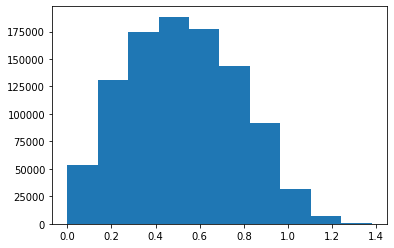

In [7]:
plt.hist(dist_mat.ravel())

## local depth:

In [8]:
tau_list = [.1,.2,.4,.6,.8,1,np.inf]

bar = progressbar.ProgressBar()
ldd = list()
for tau in bar(tau_list):
    ldd.append(local_distance_depth_function(dist_mat, tau))

100% (7 of 7) |##########################| Elapsed Time: 0:01:46 Time:  0:01:46


In [29]:
# get min/max range of density estimate:
_min = np.inf
_max = -np.inf

for idx, tau in enumerate(tau_list):
    _min = np.min([np.min(ldd[idx]), _min])
    _max = np.max([np.max(ldd[idx]), _max])
    
print(_min, _max)

0.04260372597045944 0.6909090909090909


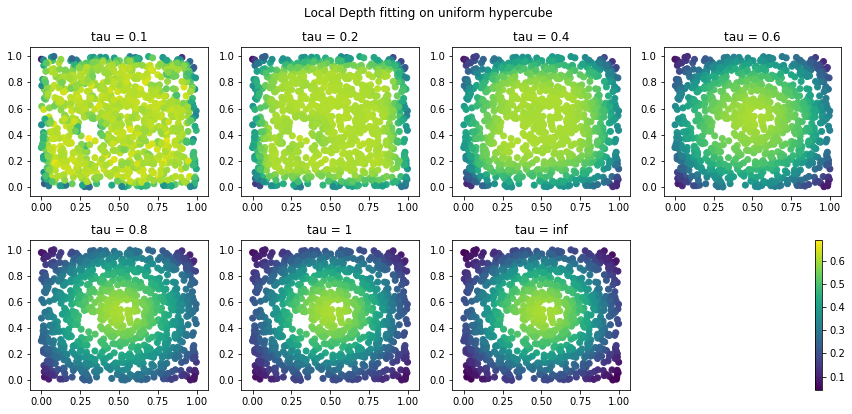

In [33]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (12,6))
ax = ax.ravel()

for idx, tau in enumerate(tau_list):
    ldd_tau_i = ldd[idx]
    cs = ax[idx].scatter(data[:,0], data[:,1], c = ldd_tau_i, 
                         vmin = _min, vmax = _max)
    ax[idx].set_title("tau = " + str(tau))

fig.colorbar(cs)
fig.delaxes(ax[7])
fig.suptitle("Local Depth fitting on uniform hypercube")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## KDE estimate

In [10]:
m1, m2 = data[:,0], data[:,1]
xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])
kernel = scipy.stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

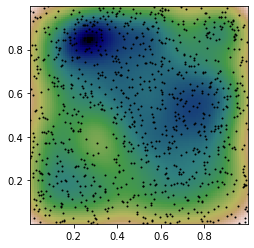

In [11]:
fig, ax = plt.subplots()
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(m1, m2, 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()

In [25]:
bw_methods = [.01,.05,.1,.2,.3,.5,1, "silverman"]
Z_list = list()
for idx, bw_method in enumerate(bw_methods):
    kernel = scipy.stats.gaussian_kde(values,bw_method = bw_method)
    Z_list.append(np.reshape(kernel(positions).T, X.shape))

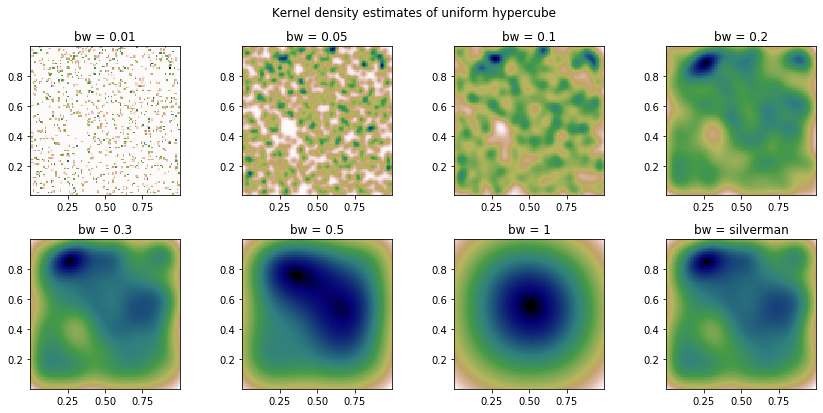

In [36]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (12,6))
ax = ax.ravel()


# # get min/max range of density estimate:
# _min_kde = np.inf
# _max_kde = -np.inf

# for idx, tau in enumerate(Z_list):
#     _min_kde = np.min([np.min(Z_list[idx]), _min_kde])
#     _max_kde = np.max([np.max(Z_list[idx]), _max_kde])
    
# print(_min, _max)

for idx, bw_method in enumerate(bw_methods):
    Z = Z_list[idx]
    cs = ax[idx].imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
                        extent=[xmin, xmax, ymin, ymax])
    ax[idx].set_title("bw = " + str(bw_method))
    
#fig.colorbar(cs)
fig.tight_layout()
fig.suptitle("Kernel density estimates of uniform hypercube")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# 2 uniform parts:

Text(0.5, 1.0, '2 separated uniform blocks')

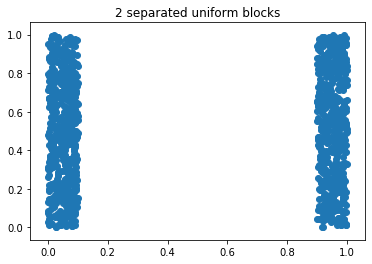

In [52]:
np.random.seed(1)
data_a = np.vstack([np.random.uniform(low = 0, high = .1,size = (500)),
                    np.random.uniform(low = 0, high = 1,size = (500))]).T
data_b = np.vstack([np.random.uniform(low = .9, high = 1,size = (500)),
                    np.random.uniform(low = 0, high = 1,size = (500))]).T

data2 = np.vstack([data_a, data_b])
plt.scatter(data2[:,0], data2[:,1])
plt.title("2 separated uniform blocks")

(array([125106., 114552.,  93036.,  71454.,  51036.,  41138., 290014.,
        153680.,  50750.,   9234.]),
 array([0.        , 0.13943189, 0.27886379, 0.41829568, 0.55772758,
        0.69715947, 0.83659137, 0.97602326, 1.11545516, 1.25488705,
        1.39431895]),
 <a list of 10 Patch objects>)

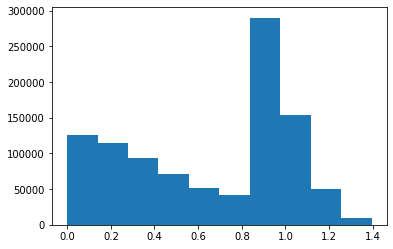

In [44]:
dist_mat2 = scipy.spatial.distance_matrix(x = data2, y = data2)
plt.hist(dist_mat2.ravel())

## local depth

In [45]:
tau_list2 = [.1,.2,.4,.6,.8,1,1.2,np.inf]

bar = progressbar.ProgressBar()
ldd2 = list()
for tau in bar(tau_list2):
    ldd2.append(local_distance_depth_function(dist_mat2, tau))

100% (8 of 8) |##########################| Elapsed Time: 0:01:36 Time:  0:01:36


In [48]:
# get min/max range of density estimate:
_min = np.inf
_max = -np.inf

for idx, tau in enumerate(tau_list):
    _min = np.min([np.min(ldd[idx]), _min])
    _max = np.max([np.max(ldd[idx]), _max])
    
print(_min, _max)

0.04260372597045944 0.6909090909090909


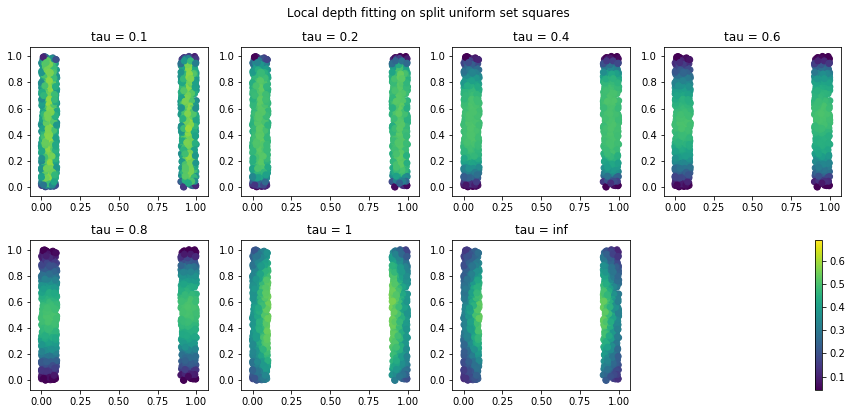

In [49]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (12,6))
ax = ax.ravel()

for idx, tau in enumerate(tau_list):
    ldd_tau_i = ldd2[idx]
    cs = ax[idx].scatter(data2[:,0], data2[:,1], c = ldd_tau_i,
                         vmin = _min, vmax = _max)
    ax[idx].set_title("tau = " + str(tau))

fig.colorbar(cs)
fig.delaxes(ax[7])
fig.suptitle("Local depth fitting on split uniform set squares")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

## kde

In [46]:
# kde
m1, m2 = data2[:,0], data2[:,1]
xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions2 = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([m1, m2])

In [47]:
bw_methods = [.01,.05,.1,.2,.3,.5,1,3, None]
Z_list2 = list()
for idx, bw_method in enumerate(bw_methods):
    kernel = scipy.stats.gaussian_kde(values,bw_method = bw_method)
    Z_list2.append(np.reshape(kernel(positions2).T, X.shape))

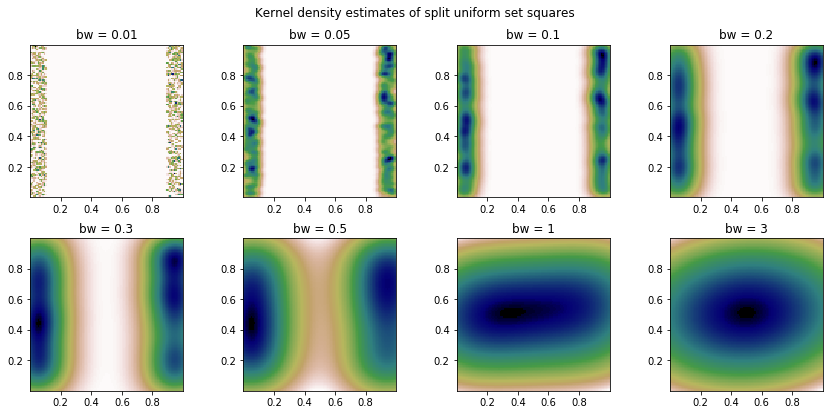

In [51]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (12,6))
ax = ax.ravel()

for idx, bw_method in enumerate(bw_methods[:(len(bw_methods)-1)]):
    Z = Z_list2[idx]
    ax[idx].imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
    ax[idx].set_title("bw = " + str(bw_method))
fig.suptitle("Kernel density estimates of split uniform set squares")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])